# Votes on Updated Locations

- Merge 2016 and 2022 datasets for summarizing votes on the two candidates Marcos and Robredo with respect to different aspects of location
- TODO might include polling center to analysis

## Prepare the datasets for merging

In [3]:
import pandas as pd
from pandas_profiling import ProfileReport
from pprint import pprint

elec_2022 = pd.read_csv("../dataset/Elections Dataset/pres_precinct_data_2022.csv")
elec_2019 = pd.read_json("../dataset/Elections Dataset/2019/philippine_provinces_cities_municipalities_and_barangays_2019v2.json")
elec_2016 = pd.read_csv("../dataset/Elections Dataset/vp_precinct_data_2016.csv")

# Rename
STDZ_2016 = {
    'barangay': 'Barangay', 
    'province': 'Province', 
    'region': 'Region', 
    'municipality': 'City', 
    'clustered_precinct': 'Precinct ID (2016)',
    'marcos': 'Marcos',
    'robredo': 'Robredo',
}
STDZ_2022 = {
    'barangay': 'Barangay', 
    'province': 'Province', 
    'region': 'Region', 
    'municipality': 'City', 
    'Precinct ID': 'Precinct ID (2022)',
    'MARCOS, BONGBONG (PFP)': 'Marcos',
    'ROBREDO, LENI (IND)': 'Robredo',
}
elec_2016.rename(columns=STDZ_2016, inplace=True)
elec_2022.rename(columns=STDZ_2022, inplace=True)

# Select locations subset w/ Precinct ID
columns_2016 = ['Precinct ID (2016)', 'Region', 'Province', 'City', 'Barangay', 'Marcos', 'Robredo']
columns_2022 = ['Precinct ID (2022)', 'Region', 'Province', 'City', 'Barangay', 'Marcos', 'Robredo']
loc_2016 = pd.DataFrame(elec_2016[columns_2016].sort_index(axis=1).reset_index(drop=True))
loc_2022 = pd.DataFrame(elec_2022[columns_2022].sort_index(axis=1).reset_index(drop=True))

# Abbreviate regions in 2022 dataset
# https://stackoverflow.com/questions/19937362/filter-string-data-based-on-its-string-length
loc_2022.loc[
    loc_2022["Region"].apply(lambda name: len(name.split()) > 2), "Region"
] = loc_2022["Region"].apply(lambda name: "".join([word[0] for word in name.split()]))

# Prepare dataframes for merging
loc_2016.sort_values(by='Precinct ID (2016)', inplace=True)
loc_2022.sort_values(by='Precinct ID (2022)', inplace=True)

# https://stackoverflow.com/questions/40251948/stop-pandas-from-converting-int-to-float-due-to-an-insertion-in-another-column
loc_2016["Precinct ID (2016)"] = pd.Series(loc_2016["Precinct ID (2016)"], dtype=object)
loc_2022["Precinct ID (2022)"] = pd.Series(loc_2022["Precinct ID (2022)"], dtype=object) 

# https://stackoverflow.com/questions/33165734/update-index-after-sorting-data-frame
loc_2016 = loc_2016.reset_index(drop=True)
loc_2022 = loc_2022.reset_index(drop=True)

# Check matched dataframes
print('Shape', loc_2016.shape, loc_2022.shape)
print(loc_2016.columns)
print(loc_2022.columns)

Shape (90642, 7) (105666, 7)
Index(['Barangay', 'City', 'Marcos', 'Precinct ID (2016)', 'Province',
       'Region', 'Robredo'],
      dtype='object')
Index(['Barangay', 'City', 'Marcos', 'Precinct ID (2022)', 'Province',
       'Region', 'Robredo'],
      dtype='object')


## Merge the dataframes and Validate

In [4]:
merged = pd.merge(
    loc_2016, 
    loc_2022, 
    how="outer",
    left_on=['Precinct ID (2016)'],
    right_on=['Precinct ID (2022)'],
    suffixes=(' (2016)', ' (2022)'),
)

sorter = [
    'Precinct ID (2016)',
    'Precinct ID (2022)',
    'Marcos (2016)',
    'Marcos (2022)',
    'Robredo (2016)',
    'Robredo (2022)',
    'Barangay (2016)',
    'Barangay (2022)',
    'City (2016)',
    'City (2022)',
    'Province (2016)',
    'Province (2022)',
    'Region (2016)',
    'Region (2022)',
]
merged = merged[sorter]

# VALIDATE by comparing to pres and vp pandas profiling reports
profile = ProfileReport(merged, title="Pandas Profiling Report")
# profile.to_file("../reports/Loc - Pandas Profiling Report.html")

## Which regions were added/ renamed/ removed since the 2016 elections and what were the total votes for the top two candidates?

In [43]:
added_renamed_removed = (merged["Region (2016)"] != merged["Region (2022)"])
added = merged["Region (2016)"].isnull()
removed = merged["Region (2022)"].isnull()
renamed = (merged["Region (2016)"].notnull() & merged["Region (2022)"].notnull() & (merged["Region (2016)"] != merged["Region (2022)"])) 

added = merged.loc[
    added, 
    [
        "Precinct ID (2016)",
        "Precinct ID (2022)",
        # "Region (2016)",
        "Region (2022)",
        # "Marcos (2016)",
        "Marcos (2022)",
        # "Robredo (2016)",
        "Robredo (2022)"
    ]
]
added = added.groupby(["Region (2022)"]).sum()

removed = merged.loc[
    removed, 
    [
        "Precinct ID (2016)",
        "Precinct ID (2022)",
        "Region (2016)",
        # "Region (2022)",
        "Marcos (2016)",
        # "Marcos (2022)",
        "Robredo (2016)",
        # "Robredo (2022)"
    ]
]
removed = removed.groupby(["Region (2016)"]).sum()

renamed = merged.loc[
    renamed, 
    [
        "Precinct ID (2016)",
        "Precinct ID (2022)",
        "Region (2016)",
        "Region (2022)",
        "Marcos (2016)",
        "Marcos (2022)",
        "Robredo (2016)",
        "Robredo (2022)"
    ]
]
renamed = renamed.groupby(["Region (2016)"]).sum()

## Which region had the most votes for Marcos for the new precincts?

<AxesSubplot:xlabel='Region (2022)'>

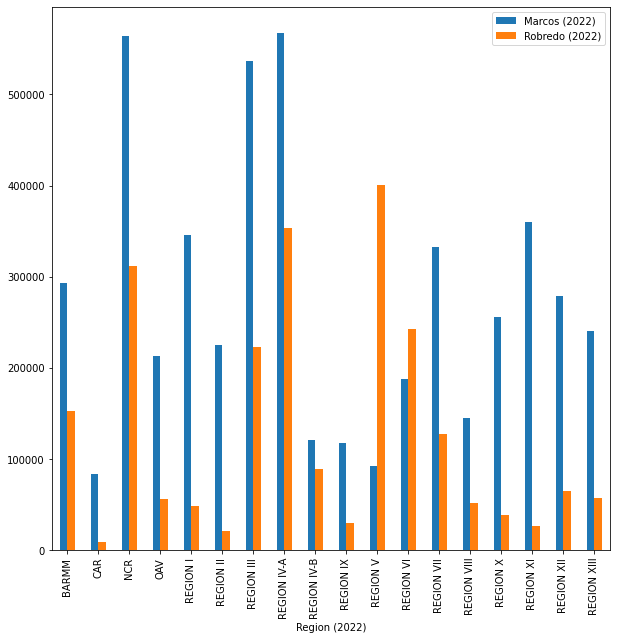

In [33]:
added.plot.bar(figsize=(10,10))

<AxesSubplot:xlabel='Region (2016)'>

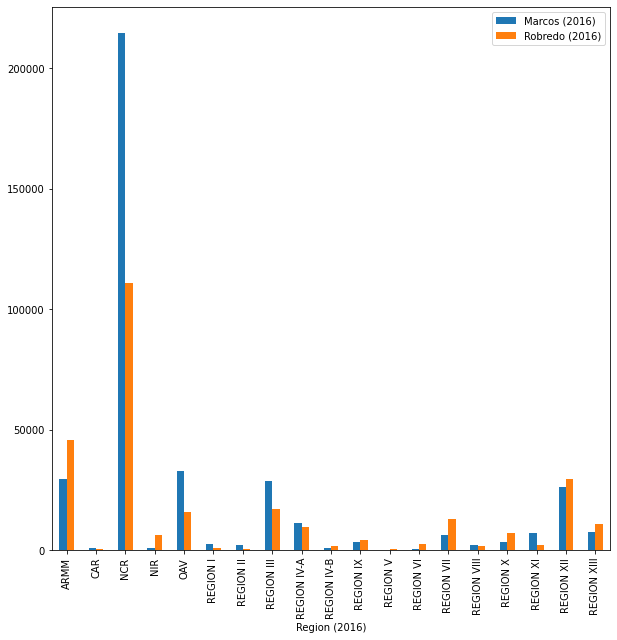

In [42]:
removed.plot.bar(figsize=(10,10))

<AxesSubplot:xlabel='Region (2016)'>

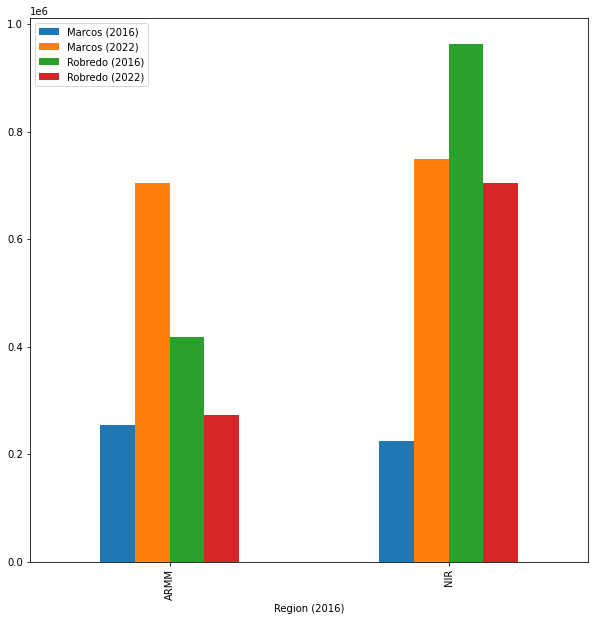

In [44]:
renamed.plot.bar(figsize=(10,10))

## Which region had the most votes for Marcos in 2016 and 2022

<AxesSubplot:xlabel='Region (2016)'>

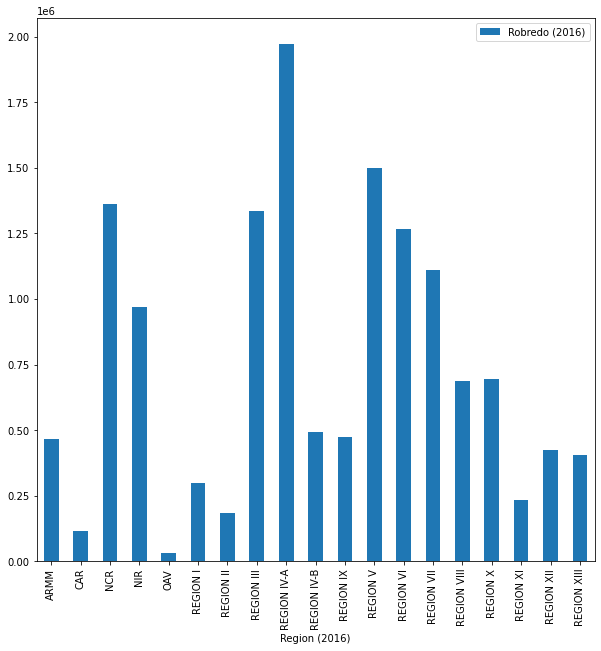

In [17]:
merged[["Region (2016)", "Robredo (2016)"]].groupby("Region (2016)").sum().plot.bar(y="Robredo (2016)", figsize=(10,10))